Embeddings are semantically meaningful compressions of information. They can be used to do similarity search, zero-shot classification or simply train a new model. Use cases for similarity search include searching for similar products in e-commerce, content search in social media and more. This notebook uses transformers, datasets and FAISS to create and index embeddings from a feature extraction model to later use them for similarity search.


we will use CLIP model to extract the features

In [1]:
!pip install -q datasets faiss-gpu transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from datasets import load_dataset

dataset = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

README.md:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.97M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

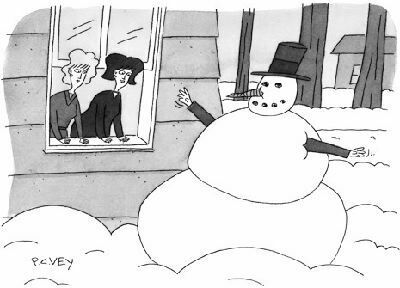

In [4]:
dataset["train"][0]["image"]

In [5]:
 dataset["train"][0]["image_description"]

'Two women are looking out a window. There is snow outside, and there is a snowman with human arms.'

We don’t have to write any function to embed examples or create an index. 🤗 datasets library’s FAISS integration abstracts these processes.

In [6]:
train_ds = dataset["train"]

ds_with_embeddings = train_ds.map(
    lambda example: {
        "embeddings": model.get_text_features(
            **tokenizer([example["image_description"]], truncation=True, return_tensors="pt").to(device)
        )[0]
        .detach()
        .cpu()
        .numpy()
    }
)

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

image embeddings

In [7]:
ds_with_embeddings = ds_with_embeddings.map(
    lambda example: {
        "image_embeddings": model.get_image_features(**processor([example["image"]], return_tensors="pt").to(device)
        )[0]
        .detach()
        .cpu()
        .numpy()
    }
)

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [8]:
# create faiss index for text and image embeddings
ds_with_embeddings.add_faiss_index(column="embeddings")
ds_with_embeddings.add_faiss_index(column="image_embeddings")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

query data with text prompts

In [9]:
prompt = "a snowy day"

prompt_embedding = (
    model.get_text_features(**tokenizer([prompt], return_tensors="pt", truncation=True).to(device)
    )[0]
    .detach()
    .cpu()
    .numpy()
)

scores, retrieved_examples = ds_with_embeddings.get_nearest_examples("embeddings", prompt_embedding, k=1)

['A man is in the snow. A boy with a huge snow shovel is there too. They are outside a house.']


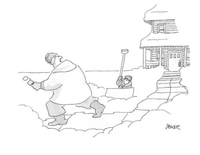

In [10]:
def downscale_images(image):
    width = 200
    ratio = width / float(image.size[0])
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    return img


images = [downscale_images(image) for image in retrieved_examples["image"]]

# see closest text and image
print(retrieved_examples["image_description"])
display(images[0])

query data with image prompts

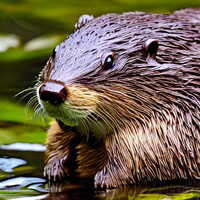

In [11]:
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png"
image = Image.open(requests.get(url, stream=True).raw)

display(downscale_images(image))

In [12]:
# search for similar img
img_embedding = (
    model.get_image_features(**processor([image], return_tensors="pt", truncation=True).to(device)
    )[0]
    .detach()
    .cpu()
    .numpy()
)

scores, retrieved_examples = ds_with_embeddings.get_nearest_examples("image_embeddings", img_embedding, k=1)

Unused or unrecognized kwargs: truncation.


['Salmon swim upstream but they see a grizzly bear and are in shock. The bear has a smug look on his face when he sees the salmon.']


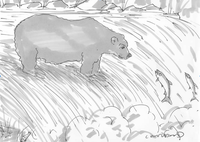

In [13]:
images = [downscale_images(image) for image in retrieved_examples["image"]]

print(retrieved_examples["image_description"])
display(images[0])

saving, pushing, loading embs

In [14]:
ds_with_embeddings.save_faiss_index("embeddings", "embeddings/embeddings.faiss")

In [15]:
ds_with_embeddings.save_faiss_index("image_embeddings", "embeddings/image_embeddings.faiss")